# Sommaire
* [Partie 1: importation et nettoyage des données](#partie1)
    * [Données clients](#section_1_1)
    * [Données produits](#section_1_2)
    * [Données_transactions](#section_1_3)
    
* [Partie 2: Réponse au mail d'Antoine](#partie2)
    * [Indicateurs et graphiques autour du chiffre d'affaire](#section_2_1)          
    * [Les références](#section_2_2)          
    * [Profils clients et répartition du chiffre d'affaire entre les clients](#section_2_3)     
    
* [Partie 3: Réponses au mail de Julie](#partie3)
    * [ Genre des clients et catégories de livres](#section_3_1)
    * [ Lien entre l'age et le montant total des achats](#section_3_2)
    * [ Lien entre l'age et la fréquence d'achat](#section_3_3)
    * [ Lien entre l'age et la taille du panier moyen ](#section_3_4)
    * [ Lien entre l'age et la catégorie de livre acheté](#section_3_5)    

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
from matplotlib import pyplot
from datetime import datetime
from datetime import timedelta
import plotly.express as px
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy.stats import spearmanr
import statistics

# Partie 1 : importation et nettoyage des données <a class="anchor" id="partie1"></a>

In [2]:
### Pour commencer, je vais importer les documents avec lesquels je vais travailler.
donnees_clients = pd.DataFrame(pd.read_csv("customers.csv"))
donnees_produits = pd.DataFrame(pd.read_csv("products.csv"))
donnees_transactions = pd.DataFrame(pd.read_csv("transactions.csv"))

## Données clients <a class="anchor" id="section_1_1"></a>

In [3]:
donnees_clients.shape

(8623, 3)

In [4]:
### Il y a 8623 lignes (clients) pour 3 colonnes (caractérisés par un id, un sexe et une date de naissance) + pas d'objets nuls + les bon types

In [5]:
### Vérification des doublons (avec client_id)
donnees_clients.duplicated('client_id').sum()

0

In [6]:
### Pas de doublons pour le dataframe "donnees_client"

In [7]:
donnees_clients.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [8]:
### Je vais devoir ajouter une colonne "age_du_client" pour la suite du projet ==> je me sert de la colonne "birth" afin de déterminer l'age de chaque client 
donnees_clients["age_client"] = 2023 - donnees_clients["birth"]
donnees_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   client_id   8623 non-null   object
 1   sex         8623 non-null   object
 2   birth       8623 non-null   int64 
 3   age_client  8623 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 269.6+ KB


## Données produit <a class="anchor" id="section_1_2"></a>

In [9]:
### donnees_produits
donnees_produits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [10]:
### Il y a 3287 produits caractérisés par un id, un prix et une catégorie + aucuns objet null = bon types 

In [11]:
### Combien y a t-il de catégories d'objets?
donnees_produits_nb_categoiries = donnees_produits.sort_values(by=['categ'], ascending=True)
donnees_produits_nb_categoiries.drop(columns=["id_prod", "price"], inplace=True)
donnees_produits_nb_categoiries_sans_doublons = set(donnees_produits_nb_categoiries["categ"].values)
print(donnees_produits_nb_categoiries_sans_doublons)

{0, 1, 2}


In [12]:
### Les produits sont caractérisés par une catégorie valant 0, 1 ou 2 (il y en a 3 en tout)

In [13]:
### Doublons suivant le id_prod
donnees_produits.duplicated('id_prod').sum()

0

In [14]:
### Aucuns doublons pour le dataframe "donnees_produits"

In [15]:
donnees_produits.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


## Données transactions <a class="anchor" id="section_1_3"></a>

In [16]:
### donnees_transactions
donnees_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


In [17]:
### Il y a 679532 transactions caractérisés par un l'id d'un produit, l'id d'un client, une date d'achat d'achat et une session (on peut acheter plusieurs produits au cours d'une session)

In [18]:
### Il y a un problème le type de la caractéristique "date", ce n'est pas le bon format ==> je vais le transformer
donnees_transactions["date"] = pd.to_datetime(donnees_transactions["date"])

ParserError: Unknown string format: test_2021-03-01 02:30:02.237419 present at position 3019

In [19]:
### Cette erreure m'indique que, au moins une donnée de la colonne "date" n'est pas au bon format
### Il s'agit de données "test", je vais regarder à quoi cela correspond
donnees_transactions.loc[donnees_transactions['date'].str.contains('test')]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [20]:
### Je m'aperçoit que toutes les dates "test" possèdent comme id_produit "T_0", les clients commencent par "ct" et les sessions par "s_0"
### Je vais donc supprimer ces données des 3 documents
donnees_clients.drop(donnees_clients[donnees_clients['client_id']=='ct_0'].index,inplace= True)
donnees_clients.drop(donnees_clients[donnees_clients['client_id']=='ct_1'].index,inplace= True)
donnees_produits.drop(donnees_produits[donnees_produits['id_prod']=='T_0'].index,inplace= True)
donnees_transactions.drop(donnees_transactions[donnees_transactions['id_prod']=='T_0'].index,inplace= True)

In [21]:
### il y a 200 lignes "test" qui ont été retirées du dataframe "donneees"
### Je retente la transformation de la date(du type "objet" au type "date")
donnees_transactions["date"] = pd.to_datetime(donnees_transactions["date"])
donnees_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 25.9+ MB


In [22]:
### le type a bien été changé
### Je vérifie qu'il n'y a pas de doublons 
donnees_transactions.duplicated('date').sum()

0

# Réponses au mail d'Antoine <a class="anchor" id="partie2"></a>

## Indicateurs et graphiques autour du chiffre d'affaire <a class="anchor" id="section_2_1"></a>

In [23]:
### Pas de duplicatats pour le dataframe "donnees_transactions"
### Nous allons pouvoir assambler nos données afin de répondre au mail d'Antoine

### Création du dataframe final <a class="anchor" id="section_2_1_1"></a>

In [24]:
### je commence par regarder les données manquantes lors de la fusion des dataframes "donnees_produits" et "donnees_transactions"
tableau_produits_transactions = pd.merge(donnees_produits, donnees_transactions,how= 'outer', indicator= True, on='id_prod')
tableau_produits_transactions_orphelins= tableau_produits_transactions[tableau_produits_transactions['_merge']!= 'both']
tableau_produits_transactions_orphelins

,id_prod,price,categ,date,session_id,client_id,_merge
39705,0_1016,35.06,0.0,NaT,NaN,NaN,left_only
62805,0_1780,1.67,0.0,NaT,NaN,NaN,left_only
162765,0_1062,20.08,0.0,NaT,NaN,NaN,left_only
177522,0_1119,2.99,0.0,NaT,NaN,NaN,left_only
181172,0_1014,1.15,0.0,NaT,NaN,NaN,left_only
...,...,...,...,...,...,...,...
679348,0_2245,NaN,NaN,2021-08-25 09:06:03.504061,s_80395,c_131,right_only
679349,0_2245,NaN,NaN,2022-03-06 19:59:19.462288,s_175311,c_4167,right_only
679350,0_2245,NaN,NaN,2022-05-16 11:35:20.319501,s_209381,c_4453,right_only
679351,0_2245,NaN,NaN,2022-02-11 09:05:43.952857,s_163405,c_1098,right_only


In [25]:
### en fusionnant les dataframes, je remarque qu'il y a des produits qui n'ont pas été vendus et qui ne possèdent pas de prix (0_2245) ==> je regarde si il y en a d'autres
tableau_produits_transactions_orphelins.loc[tableau_produits_transactions_orphelins['_merge']=='right_only']

,id_prod,price,categ,date,session_id,client_id,_merge
679132,0_2245,NaN,NaN,2022-09-23 07:22:38.636773,s_272266,c_4746,right_only
679133,0_2245,NaN,NaN,2022-07-23 09:24:14.133889,s_242482,c_6713,right_only
679134,0_2245,NaN,NaN,2022-12-03 03:26:35.696673,s_306338,c_5108,right_only
679135,0_2245,NaN,NaN,2021-08-16 11:33:25.481411,s_76493,c_1391,right_only
679136,0_2245,NaN,NaN,2022-07-16 05:53:01.627491,s_239078,c_7954,right_only
...,...,...,...,...,...,...,...
679348,0_2245,NaN,NaN,2021-08-25 09:06:03.504061,s_80395,c_131,right_only
679349,0_2245,NaN,NaN,2022-03-06 19:59:19.462288,s_175311,c_4167,right_only
679350,0_2245,NaN,NaN,2022-05-16 11:35:20.319501,s_209381,c_4453,right_only
679351,0_2245,NaN,NaN,2022-02-11 09:05:43.952857,s_163405,c_1098,right_only


In [26]:
### il n'y a qu'un seul produit dont le prix n'est pas renseigné : 0_2245 ==> je décide de lui donner une valeur (la medianne des prix de la catégorie "0") et une categorie (0)
donnees_produits_categorie_0 = donnees_produits.loc[donnees_produits["categ"] == 0]
print(statistics.median(donnees_produits_categorie_0["price"]))

10.32


In [27]:
### Je réinjecte cette valeur dans la dataframe "donnees_produits"
donnees_produits.loc[len(donnees_produits)] = info_prod_02245 = ['0_2245', 10.32,  0]
donnees_produits.tail(1)

,id_prod,price,categ
3286,0_2245,10.32,0


In [28]:
# tous les problèmes ont été corrigés ==> je réalise la jointure des 3 dataframes
transactions_produits = pd.merge(donnees_produits, donnees_transactions, on="id_prod", how="inner")
tableau_final = pd.merge(transactions_produits, donnees_clients, on="client_id", how="inner")

In [29]:
# je rajoute les colonnes "annee", "annee_mois" , "mois" et "jour"
tableau_final['annee']=tableau_final['date'].dt.year
tableau_final['annee-mois'] = tableau_final['date'].dt.strftime('%Y-%m')
tableau_final["mois"]=tableau_final['date'].dt.month
tableau_final["jour"]=tableau_final['date'].dt.day
tableau_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679328 entries, 0 to 679327
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679328 non-null  object        
 1   price       679328 non-null  float64       
 2   categ       679328 non-null  int64         
 3   date        679328 non-null  datetime64[ns]
 4   session_id  679328 non-null  object        
 5   client_id   679328 non-null  object        
 6   sex         679328 non-null  object        
 7   birth       679328 non-null  int64         
 8   age_client  679328 non-null  int64         
 9   annee       679328 non-null  int64         
 10  annee-mois  679328 non-null  object        
 11  mois        679328 non-null  int64         
 12  jour        679328 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(5)
memory usage: 72.6+ MB


### Histogramme chiffre d'affaire annuel <a class="anchor" id="section_2_1_2"></a>

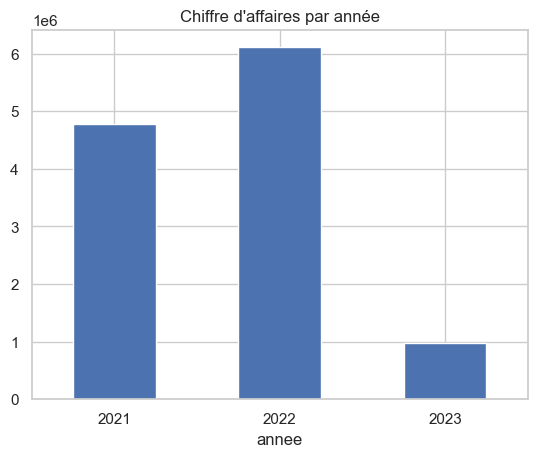

In [30]:
tableau_final.groupby('annee')['price'].sum().plot(kind = 'bar')
plt.title('Chiffre d\'affaires par année')
plt.xticks(rotation=0, ha='center')
plt.show()

In [31]:
tableau_2021 = tableau_final.loc[tableau_final["annee"] == 2021]
tableau_2022 = tableau_final.loc[tableau_final["annee"] == 2022]
tableau_2023 = tableau_final.loc[tableau_final["annee"] == 2023]

CA_2021 = tableau_2021["price"].sum()
CA_2022 = tableau_2022["price"].sum()
CA_2023 = tableau_2023["price"].sum()

print("le chiffre d'affaire pour l'année 2021 est :" , CA_2021 , "euros")
print("le chiffre d'affaire pour l'année 2022 est :" , CA_2022 , "euros")
print("le chiffre d'affaire pour l'année 2023 est :" , CA_2023 , "euros")
print("le chiffre d'affaire total est :" , CA_2021+CA_2022+CA_2023 , "euros")

le chiffre d'affaire pour l'année 2021 est : 4771674.08 euros
le chiffre d'affaire pour l'année 2022 est : 6109895.050000002 euros
le chiffre d'affaire pour l'année 2023 est : 974339.6299999999 euros
le chiffre d'affaire total est : 11855908.760000002 euros


## Evolution du chiffre d'affaire et moyenne mobile <a class="anchor" id="section_2_1_3"></a>

Le chiffre d'affaire quotidien moyen est de: 16241 €


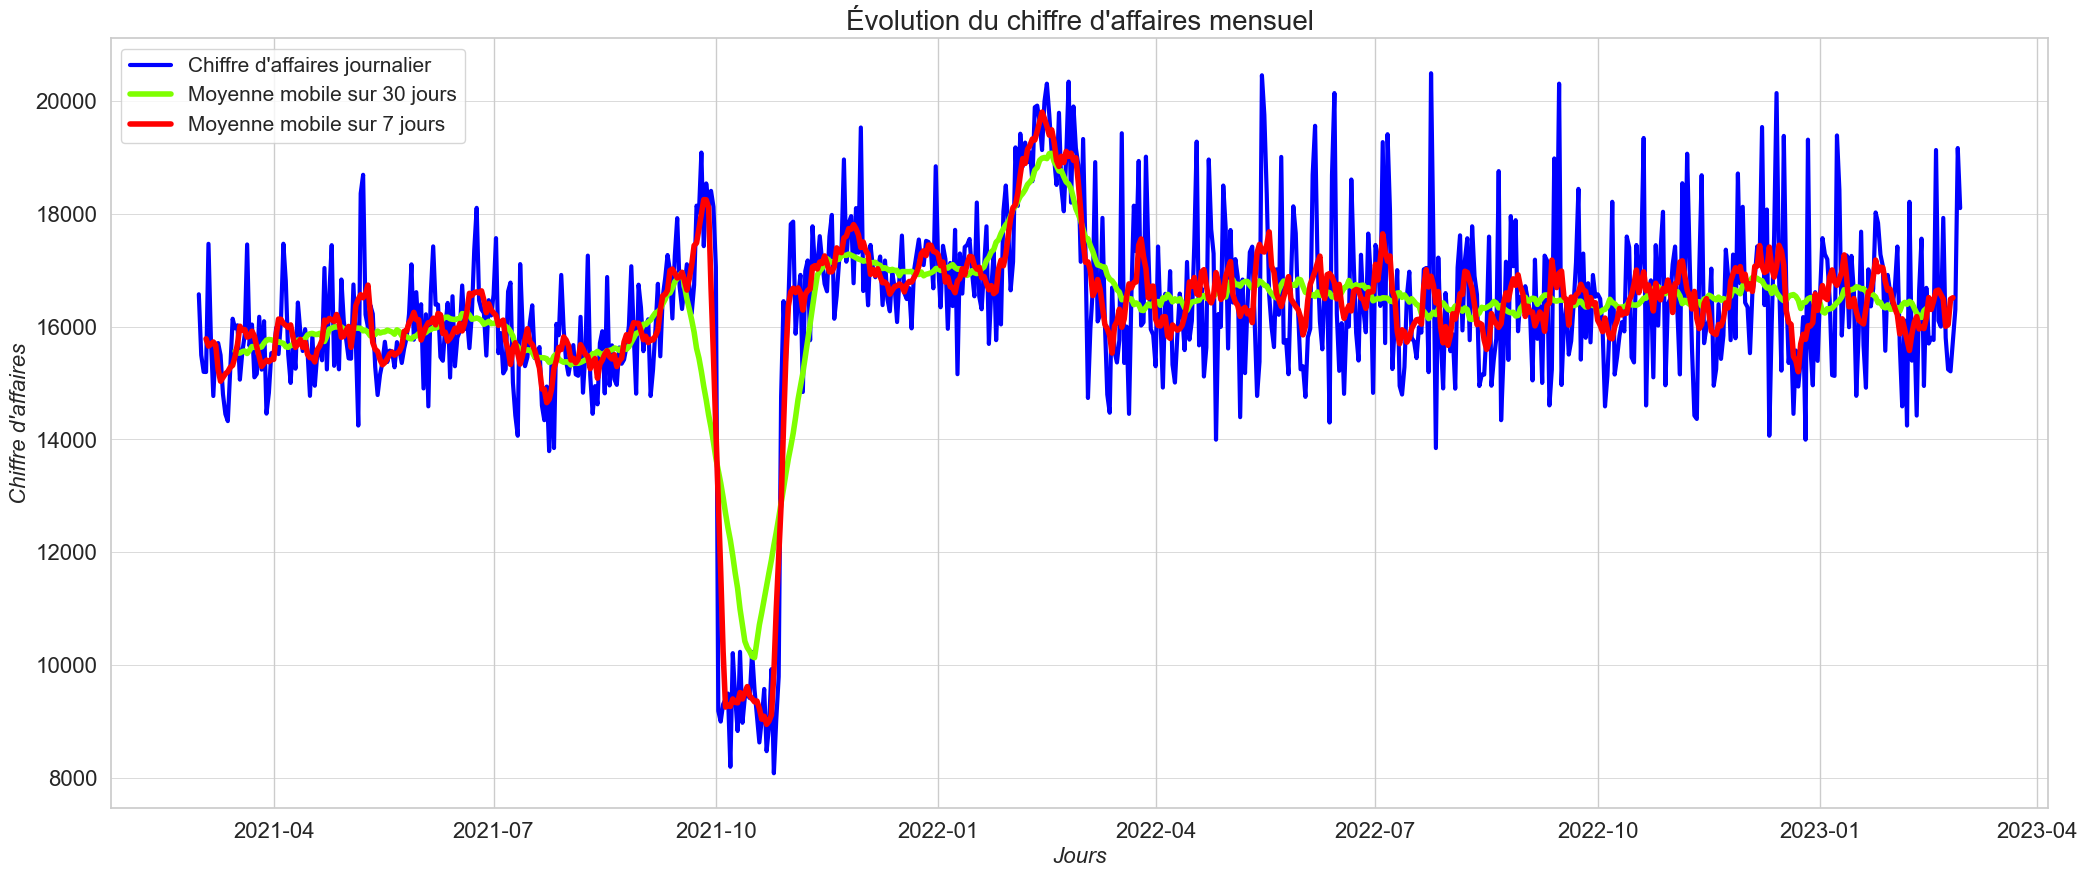

In [32]:
# cette ligne permet d'obtenir le chiffre d'affaire chaque jour
moyenne_mobile_mois = tableau_final[["date","price"]].resample("D", on="date").sum()
#moyenne mobile sur 30 jours
moyenne_mobile_mois["MM30"] = moyenne_mobile_mois["price"].rolling(30, center=True).mean()
#moyenne mobile sur 7 jours
moyenne_mobile_mois["MM7"] = moyenne_mobile_mois["price"].rolling(7, center=True).mean()

fig = plt.figure(figsize=(25,10))
ax = plt.axes()

ax.plot(moyenne_mobile_mois.index, moyenne_mobile_mois["price"], label="Chiffre d'affaires journalier", color="blue", linewidth=3, markersize=8)
ax.plot(moyenne_mobile_mois.index, moyenne_mobile_mois["MM30"], label="Moyenne mobile sur 30 jours", color="chartreuse", linewidth=4)
ax.plot(moyenne_mobile_mois.index, moyenne_mobile_mois["MM7"], label="Moyenne mobile sur 7 jours", color="red", linewidth=4)
ax.legend(fontsize=15)
ax.set_title("Évolution du chiffre d'affaires mensuel", fontsize=20)
ax.set_xlabel("Jours", fontsize=16, fontstyle="italic")
ax.set_ylabel("Chiffre d'affaires", fontsize=16, fontstyle="italic")
ax.tick_params(labelsize=16)
ax.grid(visible=True, axis="y", linewidth=0.5)

print("Le chiffre d'affaire quotidien moyen est de:",round(moyenne_mobile_mois["price"].mean()),"€")

In [33]:
# je constate une diminution brutale du CA aux alentoures de octobre 2021, je regarde de plus près
# le CA pour chaque jour de cette période est inférieu à 12000 euros ==> je regarde les dates concernées
periode_prb = moyenne_mobile_mois.loc[moyenne_mobile_mois["price"]<=12000]
periode_prb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26 entries, 2021-10-02 to 2021-10-27
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   26 non-null     float64
 1   MM30    26 non-null     float64
 2   MM7     26 non-null     float64
dtypes: float64(3)
memory usage: 832.0 bytes


In [34]:
# Il y a eu un problème pendant 26 jours ==> je regarde lesquels
periode_prb.head(26)

,price,MM30,MM7
date,,,
2021-10-02,9182.13,13451.857667,12923.288571
2021-10-03,8993.05,13226.631333,11649.000000
2021-10-04,9300.32,12972.329667,10229.438571
2021-10-05,9390.46,12689.461333,9250.725714
2021-10-06,9490.69,12432.983000,9285.472857
2021-10-07,8191.08,12210.743667,9261.558571
2021-10-08,10207.35,11935.012667,9394.450000
2021-10-09,9425.36,11627.098000,9334.548571
2021-10-10,8825.65,11356.944333,9325.481429


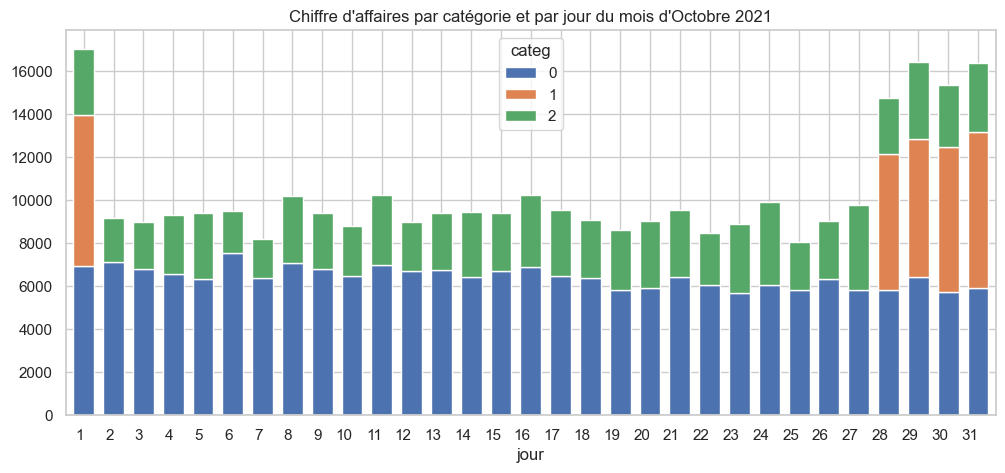

In [35]:
# Il y a eu des problèmes du 2 au 27 octobre 2021
# Je regarde quelle catégorie de produit est concerné
tableau_octobre_2021 = tableau_final.loc[(tableau_final['annee']==2021) & (tableau_final['mois']==10),:]
tableau_octobre_2021 = pd.pivot_table(tableau_octobre_2021, index = ['jour'], columns = 'categ', values = 'price',aggfunc={'price':'sum'});

#On affiche le tout sous forme de diagramme en bar
tableau_octobre_2021.plot(kind='bar',stacked = True,figsize=(12,5),width = 0.7)
plt.title("Chiffre d'affaires par catégorie et par jour du mois d'Octobre 2021")
plt.xticks(rotation =0,ha='right')
plt.show()

In [36]:
# La catégorie de produit concerné est la 1
# Je décide de retirer le CA entre ces dates
tableau_final = tableau_final.loc[~tableau_final["date"].between("2021-10-01 00:00:00.000000","2021-10-31 23:59:59.999999", inclusive="both")]

## Répartition du chiffre d'affaire par catégorie <a class="anchor" id="section_2_1_4"></a>

C:\Users\Thomas\AppData\Local\Temp\ipykernel_22464\3258871994.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tableau_categ = pd.DataFrame(tableau_final.groupby("categ").sum()["price"].sort_values(ascending=False))


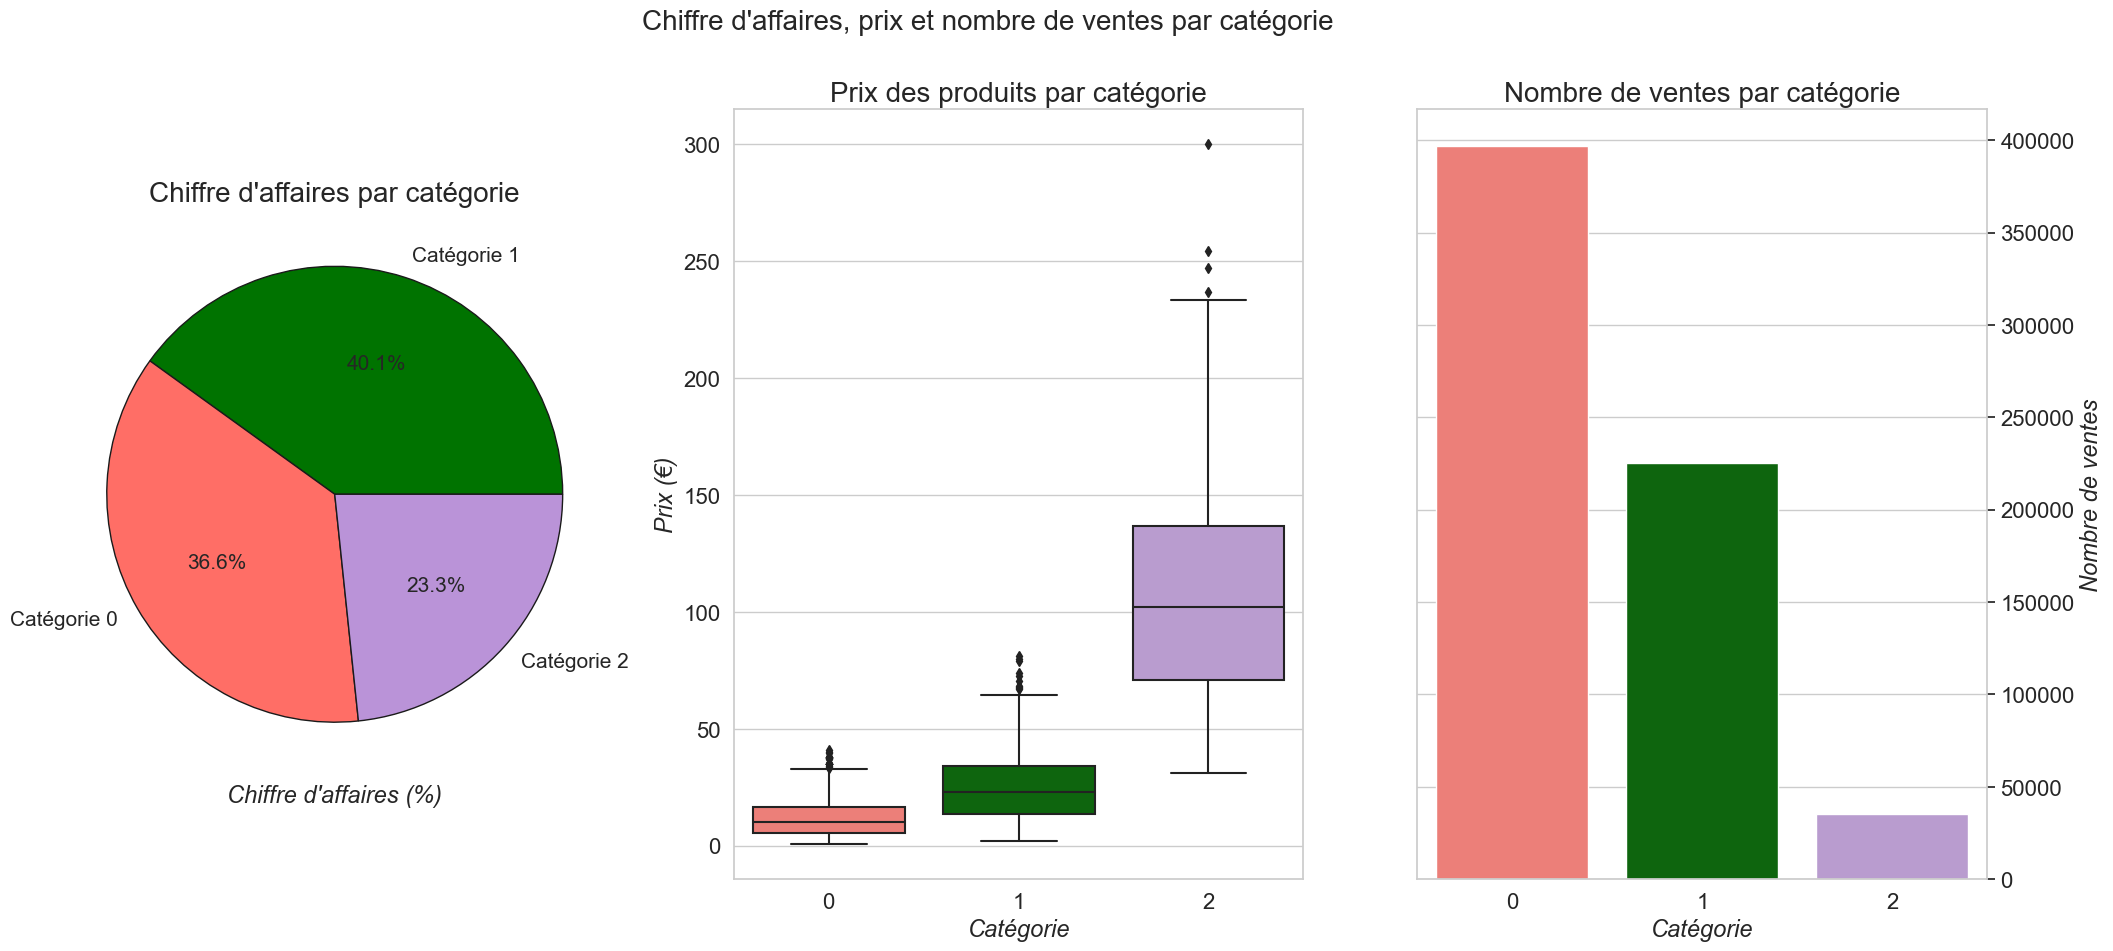

In [37]:
# Nous allons pouvoir visualiser le % du CA en fonction de la catégorie ainsi que
# la répartition des ventes et les prix des produits en fonctions de leur catégorie

tableau_categ = pd.DataFrame(tableau_final.groupby("categ").sum()["price"].sort_values(ascending=False))
tableau_vente_categ = pd.DataFrame(tableau_final.groupby("categ").count()["session_id"].sort_values(ascending=False))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))
ax1.pie(tableau_categ["price"], labels = ["Catégorie 1","Catégorie 0","Catégorie 2"], colors = ["#007300","#ff6e66","#ba93d8"], autopct='%.1f%%', wedgeprops = {'linewidth':1, 'edgecolor': 'k'}, textprops = {"fontsize":15})
ax2 = sns.boxplot(x=donnees_produits["categ"],y=donnees_produits["price"], palette=["#ff6e66","#007300","#ba93d8"], ax=ax2)
ax3 = sns.barplot(x=tableau_vente_categ.index, y="session_id", data=tableau_vente_categ, palette=["#ff6e66","#007300","#ba93d8"], ax=ax3)

fig.suptitle("Chiffre d'affaires, prix et nombre de ventes par catégorie", fontsize=20)

ax1.set_title("Chiffre d'affaires par catégorie", fontsize=20)
ax1.set_xlabel("Chiffre d'affaires (%)", fontsize=17, fontstyle= "italic")
ax1.set_ylabel("")
ax1.tick_params(labelsize=16)

ax2.set_title("Prix des produits par catégorie", fontsize=20)
ax2.set_xlabel("Catégorie", fontsize=17, fontstyle= "italic")
ax2.set_ylabel("Prix (€)", fontsize=17, fontstyle= "italic")
ax2.tick_params(labelsize=16)

ax3.set_title("Nombre de ventes par catégorie", fontsize=20)
ax3.set_xlabel("Catégorie", fontsize=17, fontstyle= "italic")
ax3.set_ylabel("Nombre de ventes", fontsize=17, fontstyle= "italic")
ax3.yaxis.set_label_position("right")
ax3.tick_params(labelsize=16,labelright=True, labelleft=False, right=True, left=False)
plt.show()

## Répartition du chiffre d'affaire en fonction du sexe <a class="anchor" id="section_2_1_5"></a>

In [38]:
### Je créé les dataframes pour les hommes et les femmes
tableau_clients_masculins = tableau_final.loc[tableau_final["sex"] == "m"]
tableau_clients_feminins = tableau_final.loc[tableau_final["sex"] == "f"]

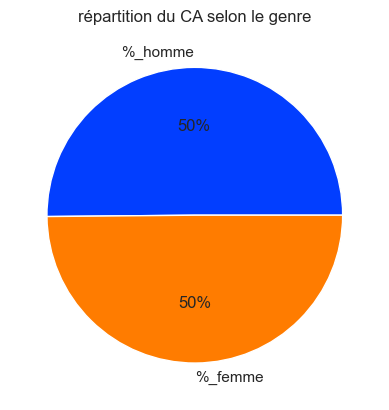

In [39]:
### Je montre par un camembert le pourcentage du CA réalisé par les hommes et les femmes
data = [tableau_clients_masculins.duplicated('sex').sum()/len(tableau_final), tableau_clients_feminins.duplicated('sex').sum()/len(tableau_final)]
labels = ['%_homme', '%_femme']
colors = sns.color_palette('bright')
pyplot.title('répartition du CA selon le genre')
plt.pie(data, labels=labels,colors = colors, autopct = '%0.0f%%')
plt.show()

In [40]:
### Les femmes comme les hommes génèrent 50% du CA

# Les références <a class="anchor" id="section_2_2"></a>

## Liste des meilleurs / pires références <a class="anchor" id="section_2_2_1"></a>

C:\Users\Thomas\AppData\Local\Temp\ipykernel_22464\437000439.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tableau_produits = pd.DataFrame(tableau_final.groupby("id_prod").sum()["price"].sort_values(ascending=False))


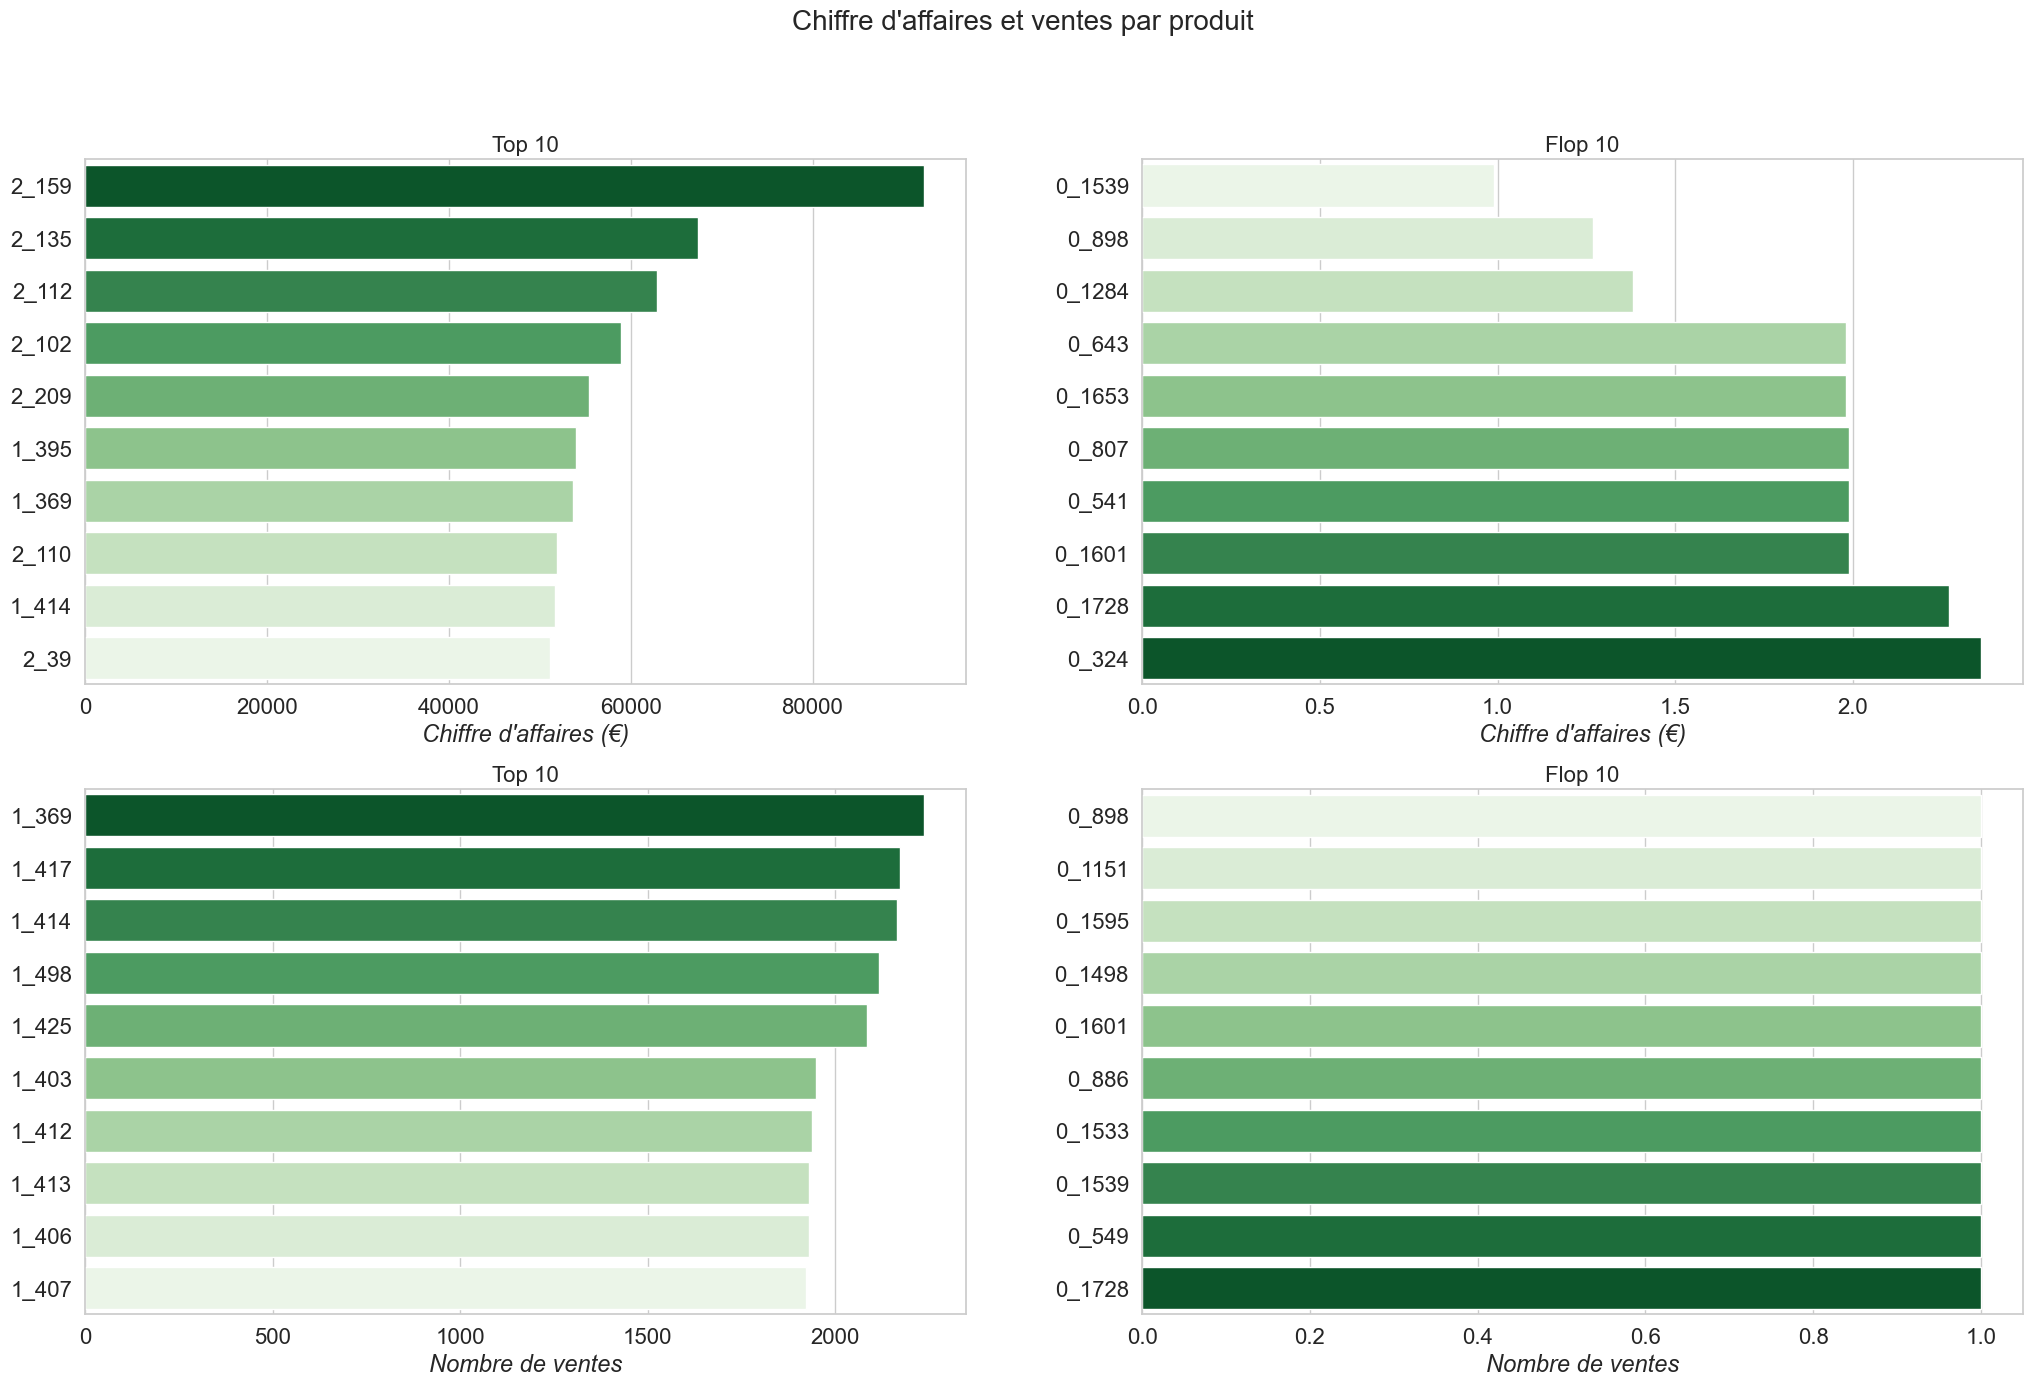

In [41]:
### Liste des 10 meilleurs/pires ventes et des 10 meilleurs/pires CA par référence
tableau_produits = pd.DataFrame(tableau_final.groupby("id_prod").sum()["price"].sort_values(ascending=False))
tableau_produits_vendus = pd.DataFrame(tableau_final.groupby(["id_prod","categ"]).count()["session_id"].sort_values(ascending=False)).reset_index(level=1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize = (25,15))
ax2 = sns.barplot(x="price",y=tableau_produits.tail(10).index,data=tableau_produits.tail(10), palette="Greens_r", ax=ax2)
ax1 = sns.barplot(x="price",y=tableau_produits.head(10).index,data=tableau_produits.head(10), palette="Greens_r", ax=ax1)
ax4 = sns.barplot(x="session_id",y=tableau_produits_vendus.tail(10).index,data=tableau_produits_vendus.tail(10), palette="Greens_r", ax=ax4)
ax3 = sns.barplot(x="session_id",y=tableau_produits_vendus.head(10).index,data=tableau_produits_vendus.head(10), palette="Greens_r", ax=ax3)
fig.suptitle("Chiffre d'affaires et ventes par produit", fontsize=20)

ax1.set_title("Top 10", fontsize=16)
ax1.set_xlabel("Chiffre d'affaires (€)", fontsize=17, fontstyle= "italic")
ax1.set_ylabel("")
ax1.tick_params(labelsize=16)

ax2.invert_yaxis()
ax2.set_title("Flop 10", fontsize=16)
ax2.set_xlabel("Chiffre d'affaires (€)", fontsize=17, fontstyle= "italic")
ax2.set_ylabel("")
ax2.tick_params(labelsize=16)

ax3.set_title("Top 10", fontsize=16)
ax3.set_xlabel("Nombre de ventes", fontsize=17, fontstyle= "italic")
ax3.set_ylabel("")
ax3.tick_params(labelsize=16)

plt.gca().invert_yaxis()
ax4.set_title("Flop 10", fontsize=16)
ax4.set_xlabel("Nombre de ventes", fontsize=17, fontstyle= "italic")
ax4.set_ylabel("")
ax4.tick_params(labelsize=16)

## Liste des produits non-vendus <a class="anchor" id="section_2_2_2"></a>

In [42]:
### Je vais regarder maintenant si des produits ont été invendus
tableau_transactions_triees = donnees_transactions.sort_values(by=['id_prod'], ascending=True)
tableau_transactions_triees.drop_duplicates(subset ="id_prod", keep = 'first', inplace=True)
donnees_produits_final = donnees_produits.loc[donnees_produits["id_prod"] != "T_0"]
donnees_produits_final_trie = donnees_produits_final.sort_values(by=['id_prod'], ascending=True)
nb_produits_non_vendus = len(donnees_produits_final["id_prod"]) - len(tableau_transactions_triees["id_prod"])
print("le nombre de produits non-vendus est de :" ,nb_produits_non_vendus, "produits")

le nombre de produits non-vendus est de : 20 produits


In [43]:
### Je vais afficher la liste des produits non-vendus
produits_non_vendus = pd.merge(donnees_produits_final["id_prod"] , tableau_transactions_triees, how="left", on="id_prod")
produits_non_vendus_afficher = pd.isnull(produits_non_vendus["session_id"])
produits_non_vendus[produits_non_vendus_afficher]

,id_prod,date,session_id,client_id
184,0_1016,NaT,NaN,NaN
279,0_1780,NaT,NaN,NaN
736,0_1062,NaT,NaN,NaN
793,0_1119,NaT,NaN,NaN
810,0_1014,NaT,NaN,NaN
845,1_0,NaT,NaN,NaN
1030,0_1318,NaT,NaN,NaN
1138,0_1800,NaT,NaN,NaN
1346,0_1645,NaT,NaN,NaN
1504,0_322,NaT,NaN,NaN


In [44]:
### La majorité des produits non-vendus appartiennent à la catégorie 0

# Profils clients et répartition du chiffre d'affaire entre les clients <a class="anchor" id="section_2_3"></a>

## Profils clients <a class="anchor" id="section_2_3_1"></a>

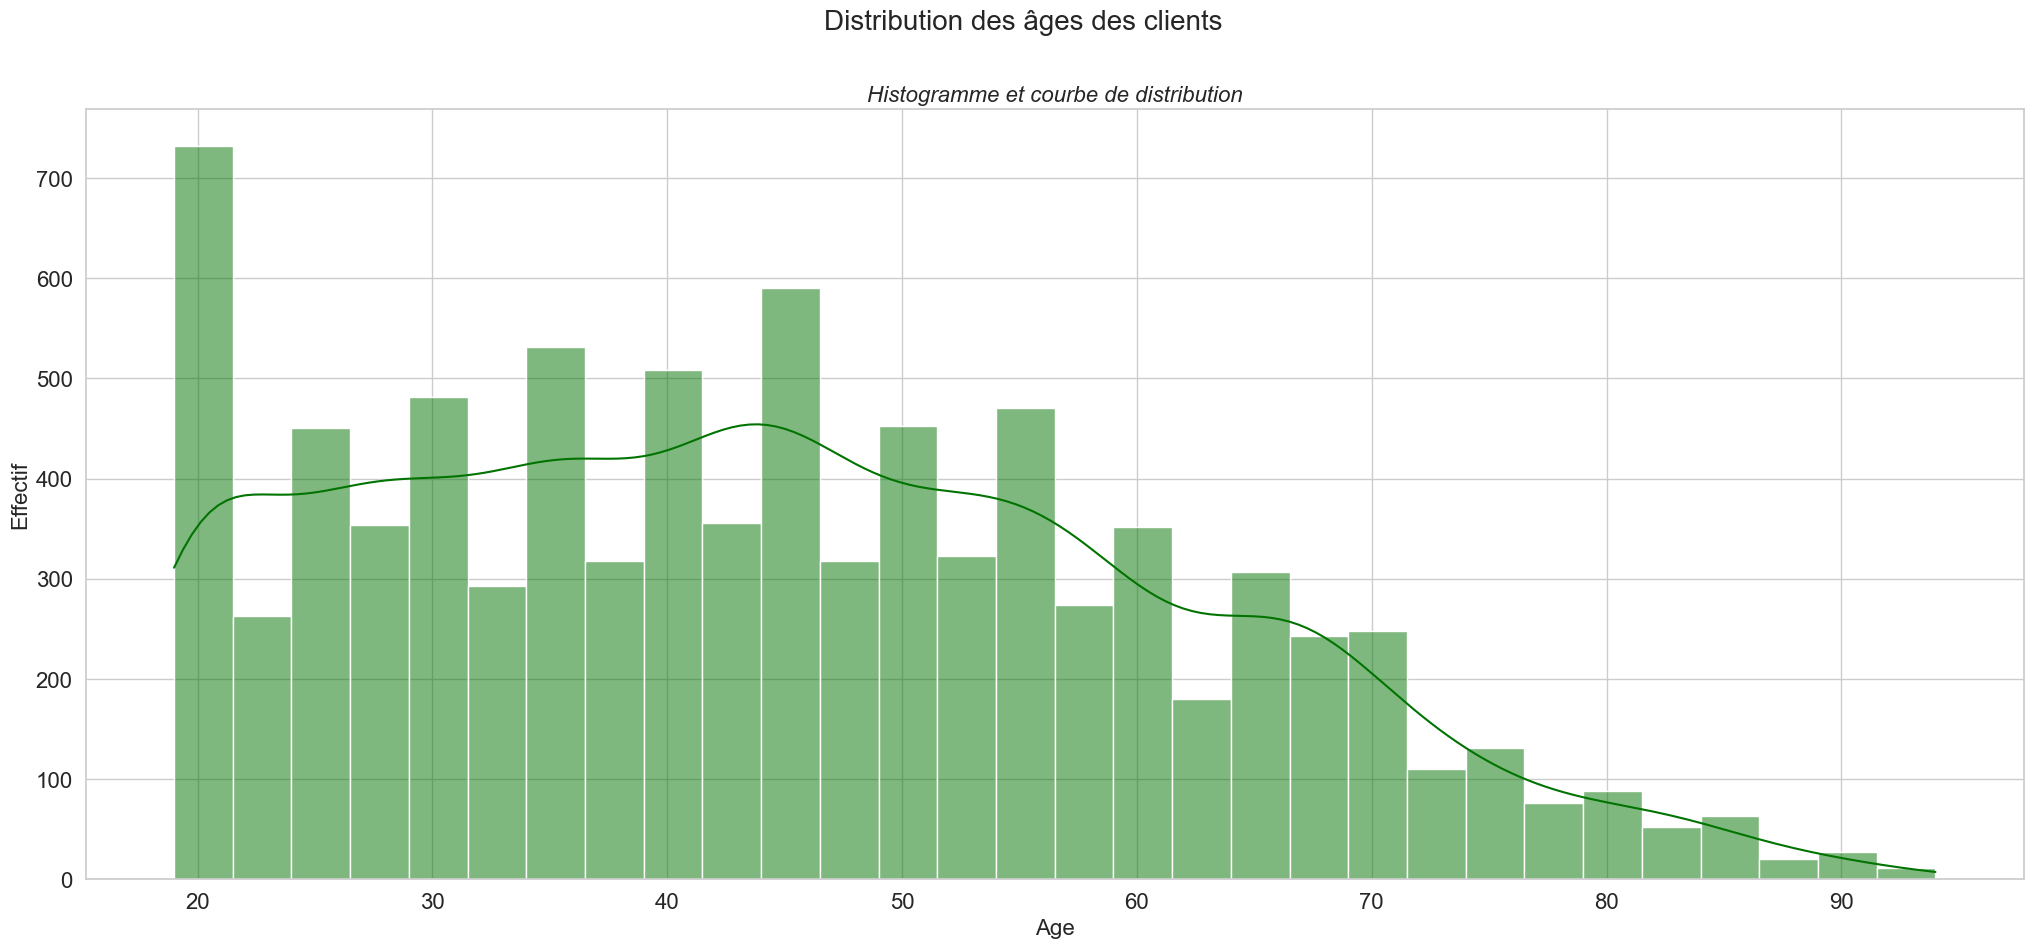

In [45]:
fig = plt.figure(figsize=(25,10))
ax = plt.axes()

ax = sns.histplot(donnees_clients["age_client"], color="#007300", kde=True)

fig.suptitle("Distribution des âges des clients", fontsize=20)
ax.set_title("Histogramme et courbe de distribution", fontsize=16, fontstyle="italic")
ax.set_xlabel("Age", fontsize=16)
ax.set_ylabel("Effectif", fontsize=16)
ax.tick_params(labelsize=16)

plt.show()

## Liste des meilleurs clients <a class="anchor" id="section_2_3_2"></a>

In [46]:
### 1)3) Informations sur le profil des clients + courbe de Lorentz
### Je commence avec les profils clients. On retrouvera: la liste des meilleurs clients + répartition des achats(par catégorie d'age) + boite à moustache afin de
### connaitre la médiane des achats de nos clients
tableau_trie_par_id_client = tableau_final.groupby("client_id").sum()
tableau_trie_par_id_client_trie_prix = tableau_trie_par_id_client.sort_values(by=["price"], ascending=False)
tableau_trie_par_id_client_trie_prix.drop(columns=["annee", "birth", "age_client"], inplace=True)
tableau_trie_par_id_client_trie_prix.head(10)

C:\Users\Thomas\AppData\Local\Temp\ipykernel_22464\791245837.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tableau_trie_par_id_client = tableau_final.groupby("client_id").sum()


,price,categ,mois,jour
client_id,,,,
c_1609,312755.08,5299,158000,388519
c_4958,282654.61,8301,32206,79222
c_6714,149845.67,4123,56866,136763
c_3454,111797.67,4067,42481,103041
c_2899,5214.05,163,576,1950
c_1570,5136.14,108,2190,5268
c_3263,5129.89,89,2490,5770
c_7319,5120.55,98,2378,6194
c_8026,4979.73,77,2456,5770


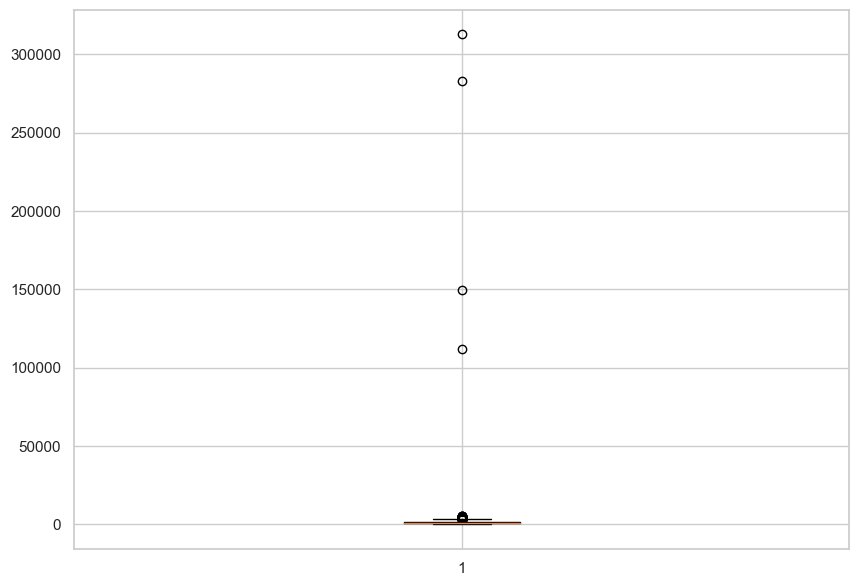

In [47]:
### Les achats des 4 premiers clients sont bien supérieurs aux autres (probablement des librairies)
### Afin de bien voir la répartition des achats des clients, je vais réaliser une boite à moustache de celle-ci
data_panier = tableau_trie_par_id_client_trie_prix['price'].values

fig = plt.figure(figsize =(10, 7)) 
plt.boxplot(data_panier) 
plt.show()

In [48]:
### Je constate que je ne vois pas grand chose car les 4 clients les plus importants distordent la boite à moustache, je décide de les retirer
tableau_trie_par_id_client_trie_prix_modif = tableau_trie_par_id_client_trie_prix.loc[tableau_trie_par_id_client_trie_prix["price"]<50000]

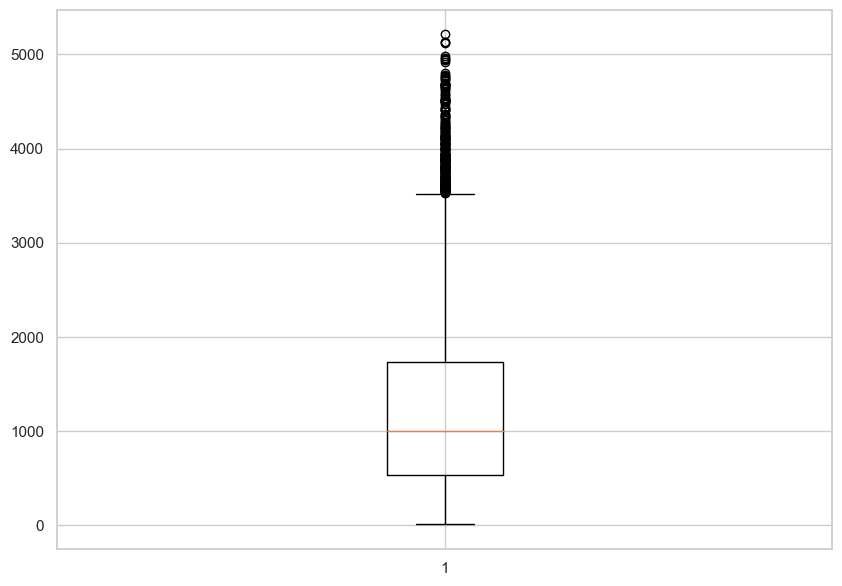

In [49]:
### Je recommence ma boite à moustache
data_panier = tableau_trie_par_id_client_trie_prix_modif['price'].values

fig = plt.figure(figsize =(10, 7)) 
plt.boxplot(data_panier) 
plt.show()

In [50]:
### Nous voyons mieux. Je peux maintenant déterminer la médiane des clients
print("La médiane des achats est : ", np.quantile(data_panier, .50), "euros")

La médiane des achats est :  1000.7 euros


## Répartition du chiffre d'affaire en fonction de la catégorie d'age des clients <a class="anchor" id="section_2_3_3"></a>

In [51]:
### Je fais la meme chose mais en fonction de l'age
### Je commence par déterminer les catégories d'age que je vais crééer
tableau_sexe_par_age = tableau_final.sort_values(by=["age_client"], ascending=True)
age_min  = np.min(tableau_sexe_par_age["age_client"])
age_max  = np.max(tableau_sexe_par_age["age_client"])
print("l'age minimum est : ",age_min, "ans" )
print("l'age maximum est : ",age_max, "ans" )

l'age minimum est :  19 ans
l'age maximum est :  94 ans


In [52]:
### Je décide de créer 3 catégories d'age : entre 19 et 39 ans, 40 et 59 ans, >59 ans
tableau_age_1 = tableau_sexe_par_age.loc[(tableau_sexe_par_age["age_client"] >= 19) & (tableau_sexe_par_age["age_client"] < 30)]
tableau_age_2 = tableau_sexe_par_age.loc[(tableau_sexe_par_age["age_client"] >= 30) & (tableau_sexe_par_age["age_client"] < 50)]
tableau_age_3 = tableau_sexe_par_age.loc[tableau_sexe_par_age["age_client"] >= 50 ]

tableau_age_1_categ = tableau_age_1.groupby("categ").sum()
tableau_age_2_categ = tableau_age_2.groupby("categ").sum()
tableau_age_3_categ = tableau_age_3.groupby("categ").sum()

C:\Users\Thomas\AppData\Local\Temp\ipykernel_22464\2944175965.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tableau_age_1_categ = tableau_age_1.groupby("categ").sum()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_22464\2944175965.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tableau_age_2_categ = tableau_age_2.groupby("categ").sum()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_22464\2944175965.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which 

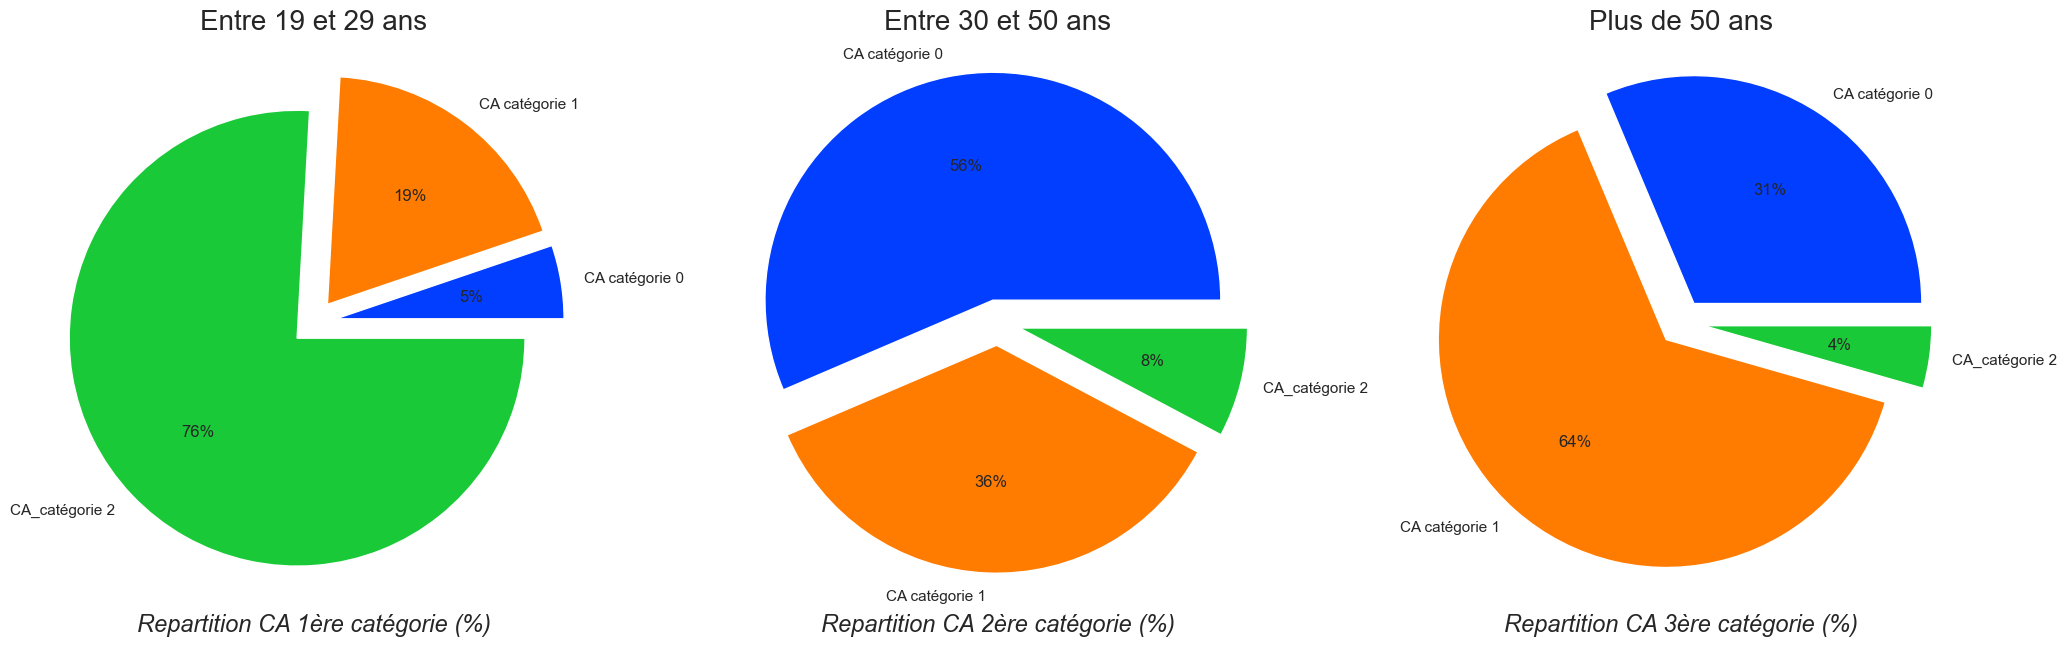

In [53]:
### Répartition des catégories d'achats pour chaque tranche d'age
### tranche 1
data1 = tableau_age_1_categ["price"].values
data2 = tableau_age_2_categ["price"].values
data3 = tableau_age_3_categ["price"].values
     
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))  
explode = [0.1, 0.1, 0.1]
labels = ['CA catégorie 0', 'CA catégorie 1', "CA_catégorie 2"]
ax1.pie(data1, labels=labels,colors = colors, autopct = '%0.0f%%', explode = explode)
ax2.pie(data2, labels=labels,colors = colors, autopct = '%0.0f%%', explode = explode)
ax3.pie(data3, labels=labels,colors = colors, autopct = '%0.0f%%', explode = explode)

ax1.set_title("Entre 19 et 29 ans", fontsize=20)
ax1.set_xlabel("Repartition CA 1ère catégorie (%)", fontsize=17, fontstyle= "italic")
ax1.set_ylabel("")
ax1.tick_params(labelsize=16)

ax2.set_title("Entre 30 et 50 ans", fontsize=20)
ax2.set_xlabel("Repartition CA 2ère catégorie (%)", fontsize=17, fontstyle= "italic")
ax2.set_ylabel("")
ax2.tick_params(labelsize=16)

ax3.set_title("Plus de 50 ans", fontsize=20)
ax3.set_xlabel("Repartition CA 3ère catégorie (%)", fontsize=17, fontstyle= "italic")
ax3.set_ylabel("")
ax3.tick_params(labelsize=16)


plt.show()

In [54]:
### Je constate que les habitudes d'achats semblent varier selon la tranche d'age

## Courbe de Lorentz <a class="anchor" id="section_2_3_4"></a>

8598


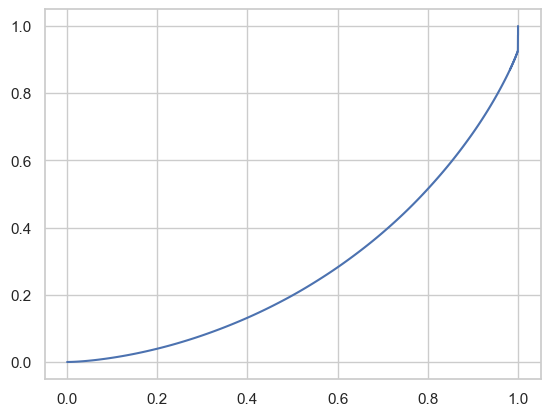

In [55]:
### Je peux maintenant déterminer la répartition du chiffre d'affaire des clients, avec la courbe de Lorentz

dep = tableau_trie_par_id_client_trie_prix['price'].values
n = len(dep)
print(n)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
# La courbe de Lorenz commence à 0
lorenz = np.append([0],lorenz) 

#Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.show()

In [56]:
### Je constate que 50% du chiffre d'affaire est réalisé par 20% des clients
### Je détermine son coefficient de gini:
### C'est une mesure statistique de l'inégalité economique au sein d'une population
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n 
# surface entre la première bissectrice et le courbe de Lorenz
S = 0.5 - AUC 
gini = 2*S
gini

0.447407754904821

In [57]:
### Le coefficient est compris entre 0 et 0.49 

# Réponses au mail de Julie <a class="anchor" id="partie3"></a>

In [58]:
### Tout ce que demendais Antoine a été fait, je peux passer à la deuxième partie du projet : répondre à Julie
### 2)1) lien entre le genre des clients et la catégorie de livres achetés
### Ici, ces 2 variables sont qualitatives ==> on utilisera le test du khi2
tableau_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 657722 entries, 0 to 679327
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     657722 non-null  object        
 1   price       657722 non-null  float64       
 2   categ       657722 non-null  int64         
 3   date        657722 non-null  datetime64[ns]
 4   session_id  657722 non-null  object        
 5   client_id   657722 non-null  object        
 6   sex         657722 non-null  object        
 7   birth       657722 non-null  int64         
 8   age_client  657722 non-null  int64         
 9   annee       657722 non-null  int64         
 10  annee-mois  657722 non-null  object        
 11  mois        657722 non-null  int64         
 12  jour        657722 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(5)
memory usage: 70.3+ MB


## Genre des clients et catégories de livres <a class="anchor" id="section_3_1"></a>

In [60]:
#Tableau de contingence
X="categ"
Y="sex"
tx=tableau_final[X].value_counts()
ty=tableau_final[Y].value_counts()
cont=tableau_final[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len).copy()
#cont=cs.copy()


cont.loc[:,"Total"]=tx
cont.loc["Total",:]=ty
cont.loc["Total","Total"]=len(tableau_final)
cont

sex,f,m,Total
categ,,,
0,197095.0,199812.0,396907.0
1,114087.0,111416.0,225503.0
2,16722.0,18590.0,35312.0
Total,327904.0,329818.0,657722.0


In [60]:
### h0 : les 2 variables sont indépendantes
### h1 : elles ne le sont pas
chi2, pvalue, degrees, expected = stats.chi2_contingency(tableau_total_final_inverse)
chi2, degrees, pvalue

(143.48438787901833, 2, 6.962433376482774e-32)

In [61]:
### on constate que la p-value << 0.05 ==> nous supposons l'hypothèse alternative (les variables sont indépendantes) ==>création de la heatmap

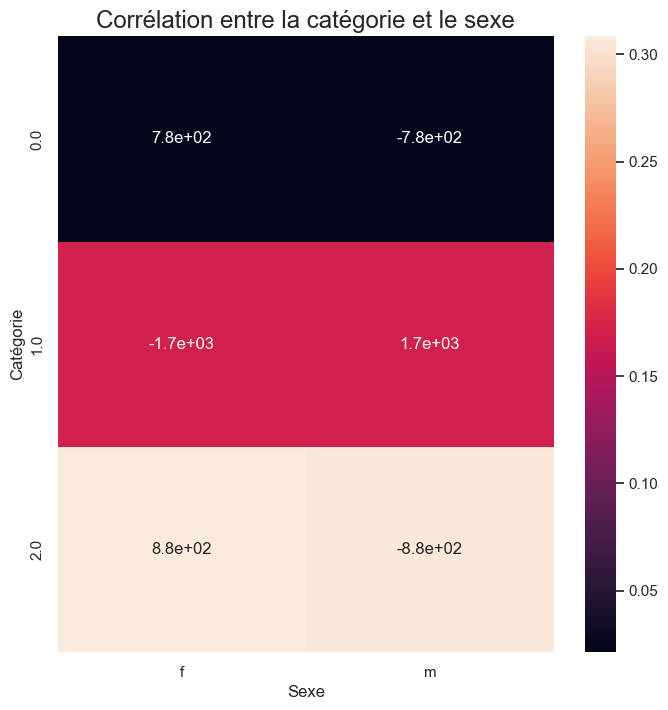

In [66]:
### création de la heatmap

tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns= ['foo']
ty.columns= ['foo']
n = len(tableau_final)
indep = tx.dot(ty.T)/n

indep.sort_index(axis=1, inplace=True)
indep.sort_index(inplace=True)

mesure = (cs-indep)**2/indep
xi_n = mesure.sum().sum()

plt.figure(figsize=(8,8))
sns.heatmap(mesure/xi_n, annot=indep - cs)
plt.title("Corrélation entre la catégorie et le sexe", fontsize = 'x-large')
plt.xlabel("Sexe")
plt.ylabel("Catégorie")
plt.show()

## Lien entre l'age et le montant total des achats <a class="anchor" id="section_3_2"></a>

In [67]:
### 2)1) Je peux passer à la determination de l'existence de liens entre l'age des clients et d'autres paramètres
### Ici, je commence par le lien entre l'age des clients et le montant total de leurs achats
### Comme tous les tests qui arriveront se feront vis à vis de l'age du client, Je vais donc effectuer un test un test de normalité (shapiro_wilk) avec l'age des clients.
### Ceci permettra de savoir directement par la suite si les tests se feront via un test de pearson/spearman (avec une variable quali et l'autre quanti) ou ANOVA/Kruskhal-Wallis(2 var quali)
from scipy.stats import shapiro

(18.0, 95.0)

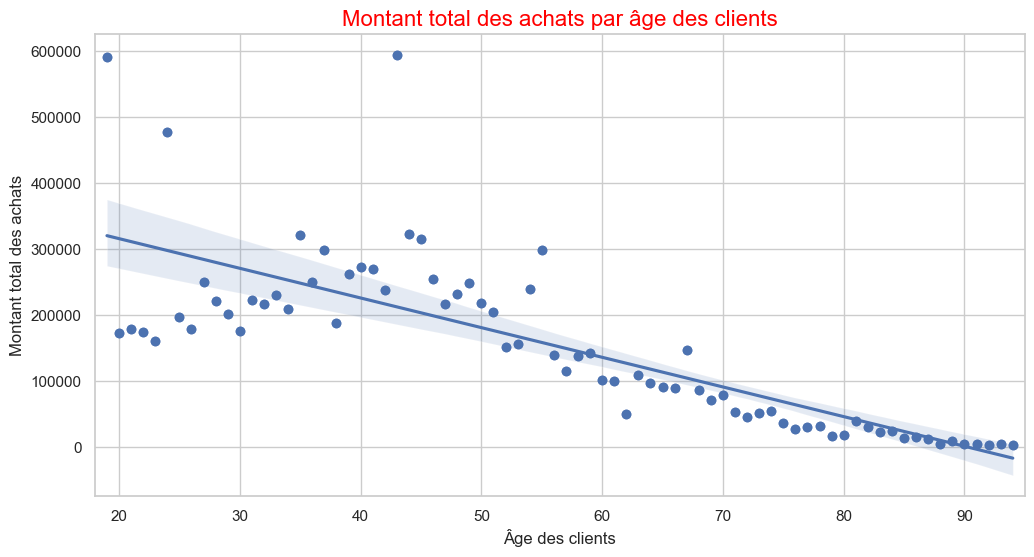

In [68]:
# Créer la dataframe avec âge et somme de CA
age_ca = tableau_final.groupby('age_client')['price'].agg(['count', 'sum']).sort_values('sum', ascending=False).reset_index()

# Nuage de points du CA en fonction d'âge des clients
plt.figure(figsize=(12, 6))
sns.regplot(x='age_client', y='sum', data = age_ca)
plt.scatter(age_ca['age_client'],age_ca['sum'])
plt.ylabel('Montant total des achats')
plt.xlabel('Âge des clients')
plt.title("Montant total des achats par âge des clients",fontsize= 16, color = 'red')
plt.xlim(18,95)

In [69]:
### h0 : l'échantillon pour l'age des clients suit une distribution normalisée
tesdt_shapiro_1 = age_ca["age_client"].values
shapiro(tesdt_shapiro_1)

ShapiroResult(statistic=0.9549236297607422, pvalue=0.008753503672778606)

In [70]:
### ici, p << 0.05 ==>on rejette H0 ==> l'échantillon ne proviens pas d'une distribution normale (n'est pas gaussien)

In [71]:
### h0 : le prix total par age suis une distribution normale
test_shapiro_2 = age_ca["sum"].values
shapiro(test_shapiro_2)

ShapiroResult(statistic=0.8884432911872864, pvalue=6.632867552980315e-06)

In [72]:
### ici, p<< 0.05 ==> je rejète h0 ==> échantillon ne suit pas une distribution normale

In [73]:
### Réalisation d'un test de spearson pour connaitre le lien entre nos 2 variables
age_ca['age_client'].corr(age_ca['sum'], method= 'spearman')

-0.857634996582365

In [74]:
### Le coefficient de spierman est proche de -1 ==> Plus on prend de l'age, moins on achète

## Lien entre l'age et la fréquence d'achat <a class="anchor" id="section_3_3"></a>

(18.0, 95.0)

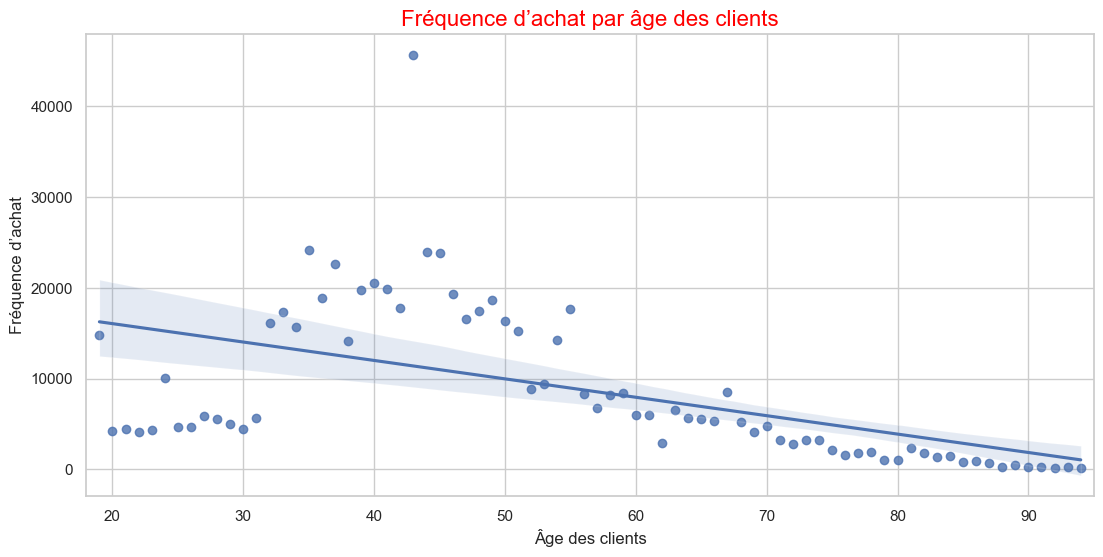

In [75]:
plt.figure(figsize=(13, 6))
sns.regplot(x='age_client', y='count', data = age_ca)
plt.ylabel( 'Fréquence d’achat')
plt.xlabel('Âge des clients')
plt.title("Fréquence d’achat par âge des clients",fontsize= 16, color = 'red')
plt.xlim(18,95)

In [76]:
### h0 : la fréquence d'achat par age ne suis pas une distribution normale
test_shapiro_2 = age_ca["count"].values
shapiro(test_shapiro_2)

ShapiroResult(statistic=0.8361814022064209, pvalue=1.0229058489130693e-07)

In [77]:
### ici, p<< 0.05 ==> je rejète h0 ==> échantillon paramétrique ==> test de spearman

In [78]:
age_ca['age_client'].corr(age_ca['count'], method= 'spearman')

-0.6841285030758715

In [79]:
### correlation negative mais forte ==> Plus on est agé, moins la fréquence d'achat est grande

## Lien entre l'age et la taille du panier moyen <a class="anchor" id="section_3_4"></a>

In [80]:
age_ca['panier_moyen'] = age_ca['sum']/age_ca['count']
age_ca.head(5)

,age_client,count,sum,panier_moyen
0,43,45621,593562.63,13.010733
1,19,14769,591414.23,40.044298
2,24,10019,476934.53,47.603007
3,44,23939,323555.50,13.515832
4,35,24173,321461.43,13.298367


Text(0.5, 1.0, 'Taille du panier moyen par âge des clients')

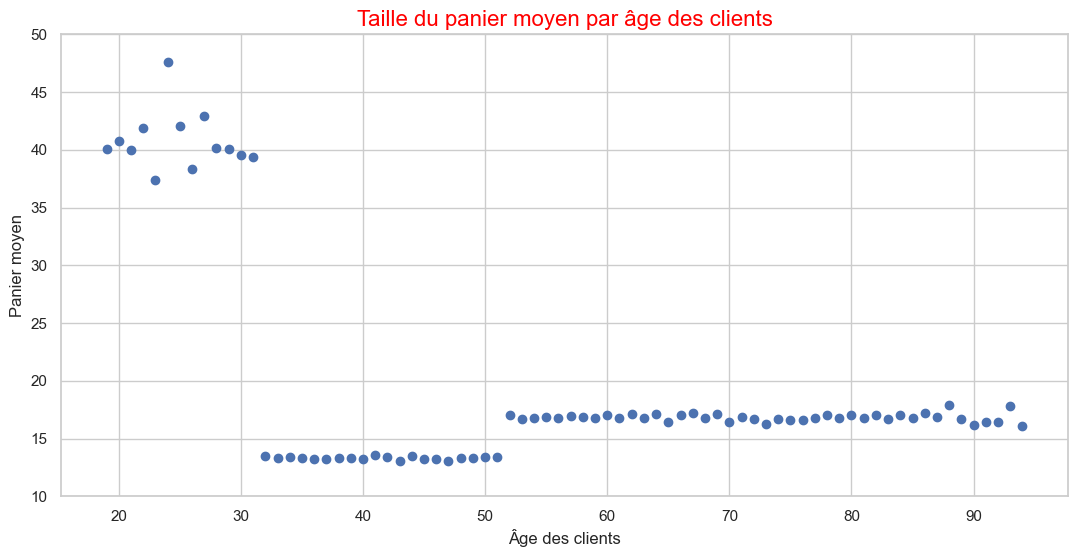

In [81]:
plt.figure(figsize=(13, 6))
plt.ylim(10,50)
plt.scatter(x='age_client', y='panier_moyen', data = age_ca)
plt.ylabel( 'Panier moyen')
plt.xlabel('Âge des clients')
plt.title("Taille du panier moyen par âge des clients",fontsize= 16, color = 'red')

In [82]:
### h0 : la taille du panier moyen par age suis une distribution normale
test_shapiro_2 = age_ca["panier_moyen"].values
shapiro(test_shapiro_2)

ShapiroResult(statistic=0.6111501455307007, pvalue=7.016537958287605e-13)

In [83]:
### ici, p<< 0.05 ==> je rejète h0 ==> échantillon paramétrique ==> test de spearman

In [84]:
age_ca['age_client'].corr(age_ca['panier_moyen'], method= 'spearman')

-0.08921394395078605

In [85]:
print('Corrélation négative légére entre les deux variables')

Corrélation négative légére entre les deux variables


In [86]:
### Plus on vieillit, plus le panier contient moins de produits

## Lien entre l'age et la catégorie de livre acheté <a class="anchor" id="section_3_5"></a>

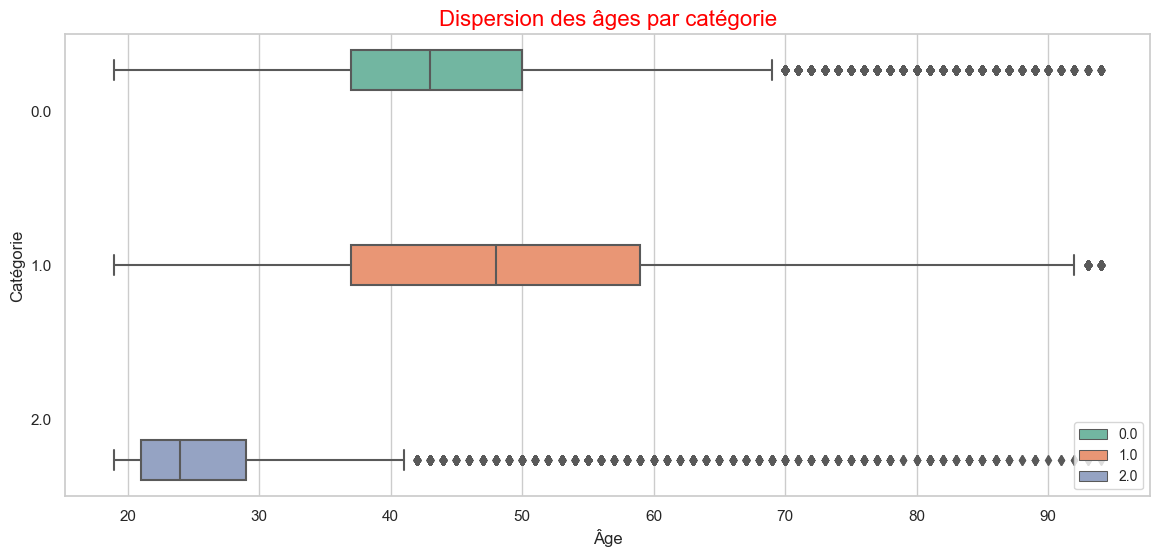

In [87]:
### Nous avons 2 variables qualitatives ==> je regarde si je peux utiliser un test ANOVA
# Dispersion des âges des clients par catégorie
categories = ['catégorie 0', 'catégorie 1', 'catégorie 2']
plt.figure(figsize=(14, 6))
sns.boxplot(y="categ", x="age_client", data = tableau_final, orient='h', hue='categ', palette='Set2')
plt.title('Dispersion des âges par catégorie',fontsize= 16, color = 'red')
plt.xlabel('Âge')
plt.ylabel('Catégorie')
plt.legend(loc='lower right', fontsize=10)

In [88]:
#Vérifions si la variable age suit une loi normale
#Avec un risque premier alpha de 5%, on émet les deux hypothèses suivantes:

# H0:la variable suit une loi normale
# H1:la variable ne suit pas une loi normale

ca_0 = tableau_final[tableau_final['categ'] == 0]['age_client']
ca_1= tableau_final[tableau_final['categ'] == 1]['age_client']
ca_2 = tableau_final[tableau_final['categ'] == 2]['age_client']

# Test de normalité se Shapiro pour la catégorie 0
stat, p = shapiro(ca_0)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Impossible de rejeter H0. La distribution semble normale')
else:
	print('On rejette H0. La distribution n\'est pas normale')

Statistics=0.936, p=0.000
On rejette H0. La distribution n'est pas normale


C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [89]:
# Test de normalité se Shapiro pour la catégorie 1
stat, p = shapiro(ca_1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Impossible de rejeter H0. La distribution semble normale')
else:
	print('On rejette H0. La distribution n\'est pas normale')

Statistics=0.989, p=0.000
On rejette H0. La distribution n'est pas normale


In [90]:
# Test de normalité se Shapiro pour la catégorie 2
stat, p = shapiro(ca_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Impossible de rejeter H0. La distribution semble normale')
else:
	print('On rejette H0. La distribution n\'est pas normale')

Statistics=0.667, p=0.000
On rejette H0. La distribution n'est pas normale


In [91]:
### La p-value pour les 3 catégories est inférieur à 5% : On rejette H0 et donc la catégorie âge ne suit pas la loi normale
### Conclusion : les conditions ne sont pas réunies pour le test d'ANOVA, nous allons transformer l'âge en une variable catégorie âge, pour pouvoir faire le test entre deux variables qualitatives

In [92]:
#Création de trois catégories d'âge dans les deux df principaux

categ_age = []

for row in tableau_final.age_client:
    if row > 50:
        categ_age.append(">50")
    elif row > 30:
        categ_age.append("30-50")
    elif row >= 18:
        categ_age.append("18-29")
    else:
        categ_age.append(np.NaN)

tableau_final['categ_age'] = categ_age

tableau_final.head()

,id_prod,price,categ,date,session_id,client_id,sex,birth,age_client,annee,annee-mois,mois,jour,categ_age
0,0_1421,19.99,0.0,2022-02-20 17:04:37.204937,s_168213,c_6389,f,1991,32,2022,2022-02,2,20,30-50
1,0_1421,19.99,0.0,2022-10-20 17:04:37.204937,s_285450,c_6389,f,1991,32,2022,2022-10,10,20,30-50
3,0_1635,16.99,0.0,2021-04-28 06:08:38.261863,s_26841,c_6389,f,1991,32,2021,2021-04,4,28,30-50
4,0_166,1.83,0.0,2021-07-15 10:35:31.526968,s_62585,c_6389,f,1991,32,2021,2021-07,7,15,30-50
5,0_166,1.83,0.0,2022-10-15 10:35:31.526968,s_282822,c_6389,f,1991,32,2022,2022-10,10,15,30-50


In [93]:
# les étapes pour réaliser ce lien :
# Tableau de contingence
# khi-deux
# Heatmap

x = 'categ_age'
y = 'categ'
cont_age = tableau_final[[x, y]].pivot_table(index=x, columns=y,aggfunc=len, margins=True, margins_name='Total' )
cont_age

categ,0.0,1.0,2.0,Total
categ_age,,,,
18-29,14729,27546,29857,72132
30-50,294898,95796,3645,394339
>50,87280,102161,1810,191251
Total,396907,225503,35312,657722


In [94]:
#Avec un risque premier alpha de 5%, on émet les deux hypothèses suivantes:
#- H0: Les deux variables (les tranches d'âge des clients et les catégories des livres achetés ) sont indépendantes
#- H1: les deux variables ne sont pas indépendantes

chi2, pvalue, degrees, expected = stats.chi2_contingency(cont_age)
chi2, degrees, pvalue

(267578.2867639999, 9, 0.0)

In [95]:
### p-value = 0 < 0,05 : On rejette H0 et on conclut que les deux variables ne sont pas indépendantes

In [96]:
# Réalisation d'une heatmap

# Tableau de contingence réel
tableau_final.categ_age = tableau_final.categ_age.astype("str")

X = "categ"
Y ="categ_age"
d = tableau_final[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len)
d.head(3)

categ_age,18-29,30-50,>50
categ,,,
0.0,14729,294898,87280
1.0,27546,95796,102161
2.0,29857,3645,1810


In [97]:
cont=d.copy()
tx=tableau_final[X].value_counts()
ty=tableau_final[Y].value_counts()

cont.loc[:,"Total"]=tx
cont.loc["total",:]=ty
cont.loc["total","Total"]=len(tableau_final)

cont

C:\Users\Thomas\AppData\Local\Temp\ipykernel_22464\2360173264.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cont.loc[:,"Total"]=tx


categ_age,18-29,30-50,>50,Total
categ,,,,
0.0,14729.0,294898.0,87280.0,396907.0
1.0,27546.0,95796.0,102161.0,225503.0
2.0,29857.0,3645.0,1810.0,35312.0
total,72132.0,394339.0,191251.0,657722.0


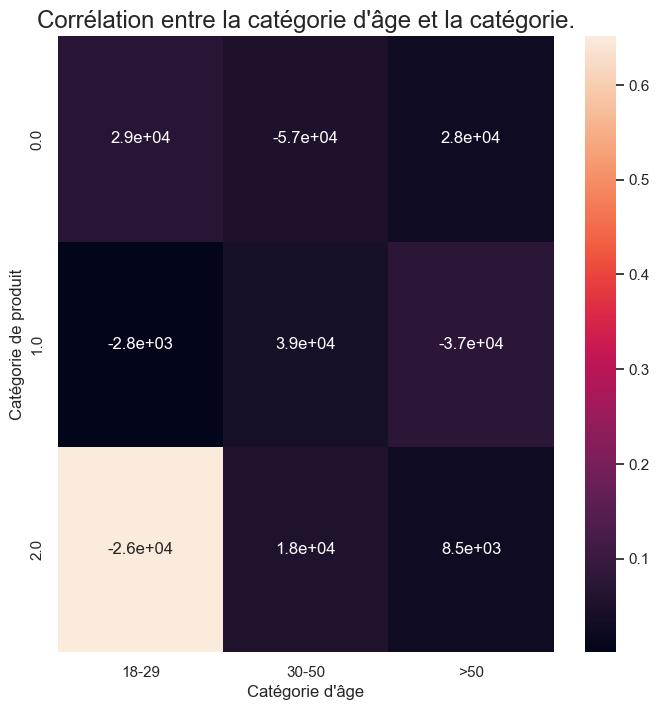

In [98]:
# Tableau de contingence théorique

tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns= ['foo']
ty.columns= ['foo']
n = len(tableau_final)
indep = tx.dot(ty.T)/n

indep.sort_index(axis=1, inplace=True)
indep.sort_index(inplace=True)

mesure = (d-indep)**2/indep
xi_n = mesure.sum().sum()

plt.figure(figsize=(8,8))
sns.heatmap(mesure/xi_n, annot=indep - d)
plt.title("Corrélation entre la catégorie d'âge et la catégorie.", fontsize = 'x-large')
plt.xlabel("Catégorie d'âge")
plt.ylabel("Catégorie de produit")
plt.show()

In [99]:
# Conclusion: On note une forte corrélation entre les personnes âgés de moins de 30 ans et la catégorie 2 de produits